In [32]:
#--Mount Google Drive
# This allows us to access files stored in Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt


In [34]:
#--Load Dataset

# Path to your dataset in Drive
file_path = '/content/drive/My Drive/stock market trend prediction/large_32.csv'

# Load CSV into pandas DataFrame
df = pd.read_csv(file_path)
df.head()  # display first 5 rows



# # load data set through this if it shows no such file or directory ' Errno 2 '
# from google.colab import files

# # Upload the CSV file manually
# uploaded = files.upload()  # Click "Choose Files" and select large_32.csv

# # Read CSV directly using the uploaded file's name
# df = pd.read_csv("large_32.csv")

# # Check first 5 rows
# df.head()

,Date Time,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 50,RSI 14,...,ALLIGATOR JAW,ALLIGATOR TEETH,ALLIGATOR LIPS,EMA 9,KAMA,KAMA COLOR,ATR,RMA 14,SMOOTH MA 14,WMA 14
0,2024-01-01 9:15:00,21727.75,21737.35,21701.80,21712.00,0,21728.43,21726.69,21725.91,40.436132,...,21729.80,21729.23,21726.73,21725.82,21728.74373,-1,11.198768,21726.67036,21726.67,21726.13333
1,2024-01-01 9:16:00,21711.50,21720.00,21695.35,21695.65,0,21721.38,21723.72,21725.55,33.330775,...,21730.06,21728.76,21722.92,21719.79,21725.60922,-1,12.159570,21724.45462,21724.45,21722.13952
2,2024-01-01 9:17:00,21697.70,21711.75,21694.75,21709.55,0,21716.03,21722.23,21725.51,42.570024,...,21729.70,21727.50,21718.98,21717.74,21725.22943,-1,12.505315,21723.39001,21723.39,21720.28095
3,2024-01-01 9:18:00,21709.55,21712.50,21698.40,21699.55,0,21709.01,21719.84,21725.37,38.442473,...,21729.18,21726.37,21716.28,21714.10,21724.65038,-1,12.619221,21721.68715,21721.69,21717.28714
4,2024-01-01 9:19:00,21704.35,21708.00,21693.55,21693.75,0,21702.10,21716.85,21725.13,36.247261,...,21728.63,21726.15,21713.18,21710.03,21722.09007,-1,12.749991,21719.69164,21719.69,21713.74619


In [35]:
#Exploratory data analysis to understand the dataset

# Check dataset column names, data types, non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92514 entries, 0 to 92513
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             92514 non-null  object 
 1   Open                  92514 non-null  float64
 2   High                  92514 non-null  float64
 3   Low                   92514 non-null  float64
 4   Close                 92514 non-null  float64
 5   Volume                92514 non-null  int64  
 6   SMA 5                 92514 non-null  float64
 7   SMA 10                92514 non-null  float64
 8   SMA 50                92514 non-null  float64
 9   RSI 14                92514 non-null  float64
 10  MACD LINE             92514 non-null  float64
 11  MACD SIGNAL           92514 non-null  float64
 12  MACD HISTOGRAM        92514 non-null  float64
 13  BOLLINGER BAND SMA    92514 non-null  float64
 14  BOLLINGER BAND UPPER  92514 non-null  float64
 15  BOLLINGER BAND LOWE

Dataset shape: (92514, 26)
Missing values in each column:
Date Time               0
Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
SMA 5                   0
SMA 10                  0
SMA 50                  0
RSI 14                  0
MACD LINE               0
MACD SIGNAL             0
MACD HISTOGRAM          0
BOLLINGER BAND SMA      0
BOLLINGER BAND UPPER    0
BOLLINGER BAND LOWER    0
ALLIGATOR JAW           0
ALLIGATOR TEETH         0
ALLIGATOR LIPS          0
EMA 9                   0
KAMA                    0
KAMA COLOR              0
ATR                     0
RMA 14                  0
SMOOTH MA 14            0
WMA 14                  0
dtype: int64


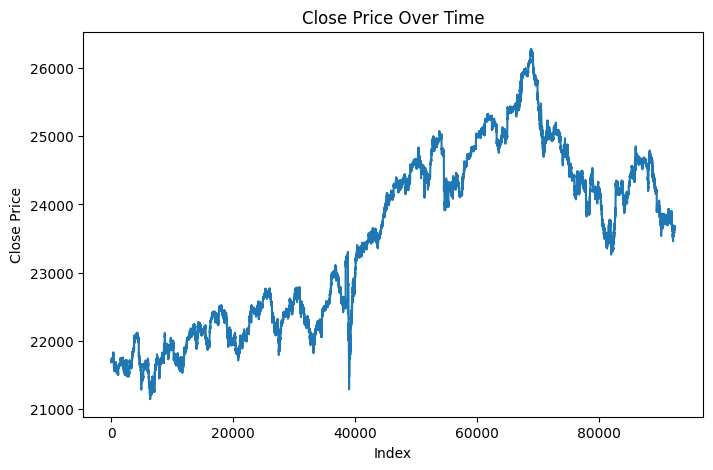

In [36]:
# Check shape of dataset (rows, columns)
print("Dataset shape:", df.shape)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check basic statistics of numeric columns
df.describe()

# Plot Close price to visualize trend
plt.figure(figsize=(8,5))
plt.plot(df['Close'])
plt.title('Close Price Over Time')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.show()


In [37]:
#Clean the data after EDA
# Drop rows with missing values (use this if we have but here in this dataset we don't have any missing values)
#df = df.dropna()


In [38]:
# Generate labels for next 5 candles
# Define labels:
# 0 = Uptrend (all next 5 candles green)
# 1 = Downtrend (all next 5 candles red)
# 2 = Neutral (mix of green & red)
labels = []
for i in range(len(df) - 5):
    next_5 = df.iloc[i+1:i+6]  # --- Look at next 5 rows
    if all(next_5['Close'] > next_5['Open']):
        labels.append(0)  #### Uptrend
    elif all(next_5['Close'] < next_5['Open']):
        labels.append(1)  #### Downtrend
    else:
        labels.append(2)  #### Neutral

# Remove last 5 rows to match labels
df = df.iloc[:-5]
df['Label'] = labels
df.loc[:, 'Label'] = labels
df.head()


,Date Time,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 50,RSI 14,...,ALLIGATOR TEETH,ALLIGATOR LIPS,EMA 9,KAMA,KAMA COLOR,ATR,RMA 14,SMOOTH MA 14,WMA 14,Label
0,2024-01-01 9:15:00,21727.75,21737.35,21701.80,21712.00,0,21728.43,21726.69,21725.91,40.436132,...,21729.23,21726.73,21725.82,21728.74373,-1,11.198768,21726.67036,21726.67,21726.13333,2
1,2024-01-01 9:16:00,21711.50,21720.00,21695.35,21695.65,0,21721.38,21723.72,21725.55,33.330775,...,21728.76,21722.92,21719.79,21725.60922,-1,12.159570,21724.45462,21724.45,21722.13952,2
2,2024-01-01 9:17:00,21697.70,21711.75,21694.75,21709.55,0,21716.03,21722.23,21725.51,42.570024,...,21727.50,21718.98,21717.74,21725.22943,-1,12.505315,21723.39001,21723.39,21720.28095,2
3,2024-01-01 9:18:00,21709.55,21712.50,21698.40,21699.55,0,21709.01,21719.84,21725.37,38.442473,...,21726.37,21716.28,21714.10,21724.65038,-1,12.619221,21721.68715,21721.69,21717.28714,2
4,2024-01-01 9:19:00,21704.35,21708.00,21693.55,21693.75,0,21702.10,21716.85,21725.13,36.247261,...,21726.15,21713.18,21710.03,21722.09007,-1,12.749991,21719.69164,21719.69,21713.74619,2


In [39]:
# Select Features and Normalize
features = ['Open','High','Low','Close','Volume','SMA 5','SMA 10','SMA 50',
            'RSI 14','MACD LINE','MACD SIGNAL','MACD HISTOGRAM']

X = df[features].values
y = df['Label'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
#Create Window size for LSTM

window_size = 20
X_seq, y_seq = [], []

for i in range(len(X_scaled) - window_size):
    X_seq.append(X_scaled[i:i+window_size])
    y_seq.append(y[i+window_size])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)  # (samples, window_size, features)
print("y_seq shape:", y_seq.shape)

X_seq shape: (92489, 20, 12)
y_seq shape: (92489,)


In [41]:
# Train-test split the data

split = int(0.8 * len(X_seq))  # 80% training, 20% testing
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 73991
Test samples: 18498


In [42]:
#  LSTM(Long Short-Term Memory) Model

model = Sequential([
    LSTM(64, input_shape=(window_size, X_seq.shape[2]), return_sequences=False),
    Dropout(0.2),  # prevent overfitting
    Dense(32, activation='relu'),  # hidden layer
    Dense(3, activation='softmax')  # output layer: 3 classes
])

# Compile model with optimizer, loss, and metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,891 (85.51 KB)

 Trainable params: 21,891 (85.51 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
#Train the Model

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9293 - loss: 0.2981 - val_accuracy: 0.9414 - val_loss: 0.2734
Epoch 2/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9426 - loss: 0.2621 - val_accuracy: 0.9414 - val_loss: 0.2645
Epoch 3/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9422 - loss: 0.2631 - val_accuracy: 0.9414 - val_loss: 0.2649
Epoch 4/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9420 - loss: 0.2634 - val_accuracy: 0.9414 - val_loss: 0.2639
Epoch 5/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9449 - loss: 0.2529 - val_accuracy: 0.9414 - val_loss: 0.2640
Epoch 6/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9412 - loss: 0.2663 - val_accuracy: 0.9414 - val_loss: 0.2638
Epoch 7/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.9439 - loss: 0.2564 - val_accuracy: 0.9414 - val_loss: 0.2644
Epoch 8/20
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9444 -

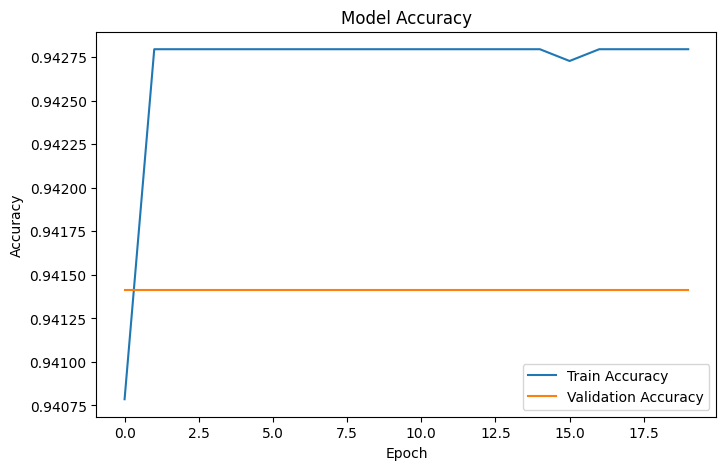

In [48]:
#---Plot Training History

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




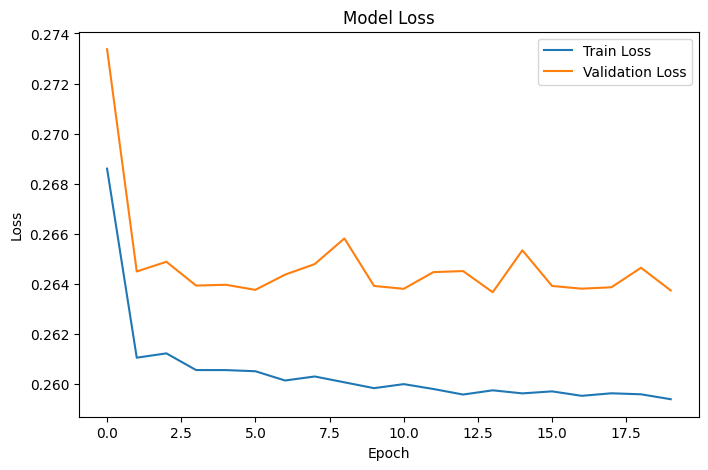

In [49]:
# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9353 - loss: 0.2853
Test Accuracy: 0.9386
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


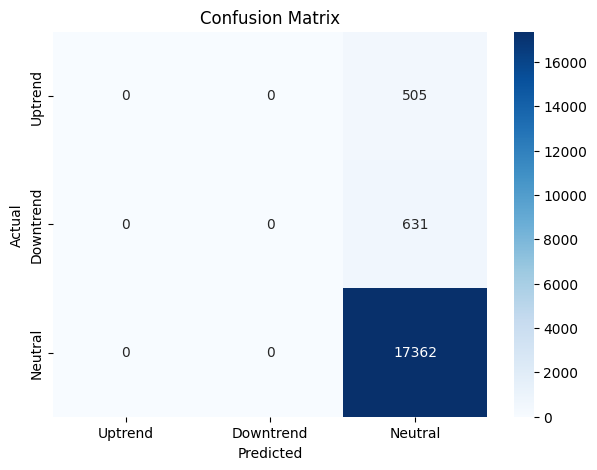

Classification Report:
              precision    recall  f1-score   support

     Uptrend       0.00      0.00      0.00       505
   Downtrend       0.00      0.00      0.00       631
     Neutral       0.94      1.00      0.97     17362

    accuracy                           0.94     18498
   macro avg       0.31      0.33      0.32     18498
weighted avg       0.88      0.94      0.91     18498



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
# Evaluate Model on Test Set

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uptrend','Downtrend','Neutral'], yticklabels=['Uptrend','Downtrend','Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Uptrend','Downtrend','Neutral']))


In [51]:
# Save the Trained Model

# Save the model to Google Drive for future use
model.save('/content/drive/MyDrive/stock model.keras')
print("Model saved successfully!")

Model saved successfully!
